<br>
<h1 style = "font-size:60px; font-family:Garamond ; font-weight : normal; background-color: #f6f5f5 ; color : #fe346e; text-align: center; border-radius: 100px 100px;">MultiClass Sentiment Analysis using BERT</h1>
<br>

Edited by Adam Ward

January 2025

Original model training done by Ashish Motwani on Kaggle

Link: https://www.kaggle.com/code/ashishmotwani/multiclass-sentiment-analysis-bert

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#5642C5; border-radius: 100px 100px; text-align:center">Import Required Libraries</h1></span>

In [2]:
import numpy as np 
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer
from transformers import BertModel

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#5642C5; border-radius: 100px 100px; text-align:center">Loading Data 📅</h1></span>

In [3]:
df = pd.read_csv('../input/sentiment-dataset-with-1-million-tweets/dataset.csv').query('Language == "en"').head(250000)
df.head(5)

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative


<AxesSubplot:xlabel='Label'>

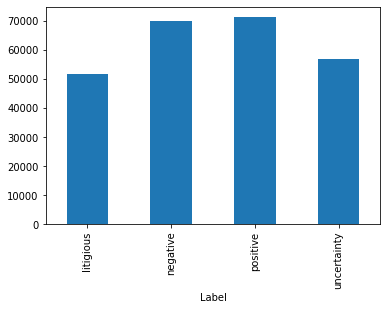

In [4]:
df.groupby(['Label']).size().plot.bar()

> ### **We have four classes in our dataset:**
1. > ### **Positive**
2. > ### **Negative**
3. > ### **Uncertain**
4. > ### **Litigious**

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#5642C5; border-radius: 100px 100px; text-align:center">Cleaning Tweets🧹  </h1></span>

> ### **We preprocess the tweets and remove all unnecessary links, emojis, symbols.**

In [5]:
def remove_emoji(string):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', string) 


def clean_tweet(tweet):
    if type(tweet) == float:
        return ""
    temp = tweet.lower()
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)
    temp = re.sub("#","", temp)
    temp = remove_emoji(temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub('[()!?]', ' ', temp)
    temp = re.sub('\[.*?\]',' ', temp)
    temp = re.sub("[^a-z0-9]"," ", temp)
    
    return temp

> ## Perform the Cleaning ##

In [7]:
df['Text'] = df['Text'].map(lambda x : clean_tweet(x))

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#5642C5; border-radius: 100px 100px; text-align:center"> Converting Text into Tokens</h1></span>

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'positive': 0,
          'negative': 1,
          'uncertainty': 2,
          'litigious': 3,
          }

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#5642C5; border-radius: 100px 100px; text-align:center"> Creating Dataset </h1></span>

> ### **Since all the tweets are of different size , we'll zero-pad them to the max length : 512**

In [9]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['Label']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['Text']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

> ## Create the train-validate-test split

In [11]:
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

> ### **No. of Training Examples : 200k**
> ### **No. of Validation Examples : 25k**
> ### **No. of Testing Examples : 25k**

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#5642C5; border-radius: 100px 100px; text-align:center">Creating Model  </h1></span>

> ### **We'll use the pretrained *BERT Base Model* and fine tune it to our dataset**

In [12]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 4)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, out = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        out = self.dropout(out)
        out = self.linear(out)
        out = self.relu(out)

        return out

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#5642C5; border-radius: 100px 100px; text-align:center"> Train and Validation Loop ➿ </h1></span>

In [13]:
from torch.optim import Adam
from tqdm import tqdm
import torch
import torch.nn as nn

def train(model, train_data, val_data, learning_rate, epochs, save_path='model_iter_{iter_num}.pt', save_interval=10000):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    iteration = 0  # To track the global number of iterations

    for epoch_num in range(epochs):

        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):

            iteration += 1  # Increment the iteration count

            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)
            
            batch_loss = criterion(output, train_label.long())
            total_loss_train += batch_loss.item()
            
            acc = (output.argmax(dim=1) == train_label).sum().item()
            total_acc_train += acc

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()

            # Save the model every `save_interval` iterations
            if iteration % save_interval == 0:
                torch.save(model.state_dict(), save_path.format(iter_num=iteration))
                print(f"Model saved at iteration {iteration}")
        
        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for val_input, val_label in val_dataloader:

                val_label = val_label.to(device)
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, val_label.long())
                total_loss_val += batch_loss.item()
                
                acc = (output.argmax(dim=1) == val_label).sum().item()
                total_acc_val += acc
        
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [ ]:
EPOCHS = 2
model = BertClassifier()
LR = 1e-6
train(model, df_train, df_val, LR, EPOCHS)

# <span><h1 style = "font-family: garamond; font-size: 40px; font-style: normal; letter-spcaing: 3px; background-color: #f6f5f5; color :#5642C5; border-radius: 100px 100px; text-align:center"> Evaluation Loop☑️ </h1></span>

In [ ]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad(): 

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    
evaluate(model, df_test)

> ## Test Accuracy: 97%

In [31]:
def predict(model, new_data, model_path, batch_size=2, device='cuda' if torch.cuda.is_available() else 'cpu'):

    # Load the pretrained model's weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()  # Set model to evaluation mode

    # Prepare the new dataset
    new_dataset = Dataset(new_data)
    new_dataloader = DataLoader(new_dataset, batch_size=batch_size, shuffle=False)

    predictions = []

    with torch.no_grad():
        for data_input in tqdm(new_dataloader):

            # load in the data specs
            data = data_input[0]
            mask = data['attention_mask'].to(device)
            input_id = data['input_ids'].squeeze(1).to(device)
                
            # Forward pass to get predictions
            output = model(input_id, mask)

            # Get the predicted labels
            predicted_labels = output.argmax(dim=1)

            # Store the predictions
            predictions.extend(predicted_labels.cpu().numpy())

    return predictions


> ## We now predict the labels for the Avatar dataset

In [ ]:
# import the data set
atla = pd.read_csv('../input/atla-full-data/atla_script.csv')

# run the prediction using the last-computed model weights
model = BertClassifier()
pred = predict(model=model, new_data=atla, model_path='../input/atla-full-data/final_model.pt')

In [37]:
# put the predictions into the data set and export for further analysis
atla.loc[:, "Label"] = pred
atla.to_csv("atla_with_predictions.csv")